# Business Problem

Syria Tel is a telecom company that is reaching out to us to reduce customers leaving their service for another provider (defined as churn). To do this we will analyze information and create a model that will predict if a customer is at risk of leaving, as well as try to determine what factors are causing customrs to want to leave.


In [1]:
import warnings

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# from dtreeviz.trees import dtreeviz
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Set Random Seed
np.random.seed(1989)

# Remove warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('./Churn_Telecom.csv')
data. head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
# Rename columns, replace space with underscore
new_columns = [i.replace(' ', '_') for i in data.columns]
data.columns = new_columns
data

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


After initial review of data, we see some good things about the data:
1. There are no missing values.
2. There do not appear to be outliers

This means that we can should not have to drop any of our data or make any guesses on what any datapoints "should" be. For convenience, we changed the column names to use underscores rather than spaces.

Next we want to pre-process our data. There are two parts to this:
1. We want to have our categorical data (such as state) be used by our models. To do so, we can use OneHotEncoder to change them to numeric representations of true or false (ie if a customer lives in Illinois, there will be an Illinois column set to 1 while all other state columns are set to 0.
2. We want all numeric data on the same scale. Account length will naturally have lower numbers than total day minutes, since it is easier to accrue minutes than months. In preprocessing we will use StandardScaler to change numbers to be between 0 and 1, relative to other numbers in the column so higher numbered columns do not influence our model moret than they should.

Area code is currently counted as numeric data, but we will change it to an object to treat it as categorical. 

In [4]:
data['area_code'] = data['area_code'].astype('object')

In [5]:
from prep import preprocess
X, y = preprocess(data)

With our data pre-processed, we can build a baseline model. We will take the data as is and start with a logistic regression model to try and predict whether a customer will churn or not.

In [6]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [7]:
baseline_model = LogisticRegression()

baseline_model.fit(X_train, y_train)

baseline_model.score(X_train, y_train)

0.8643457382953181

This model appears to already be good, but its important to look a bit deeper.

In [8]:
y_test.value_counts(normalize=True)

False    0.866906
True     0.133094
Name: churn, dtype: float64

In [9]:
y_preds = baseline_model.predict(X_train)

recall_score(y_train, y_preds)

0.23118279569892472

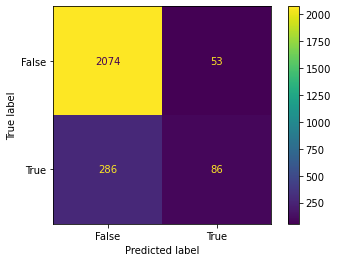

In [10]:
plot_confusion_matrix(baseline_model, X_train, y_train);

We can see that the baseline model usually just predicts that the customer is not going to leave, and since about 85% of customers stay, the model can just always say the customer will stay and be right 85% of the time. From the confusion matrix above, we can see that our test only found 3 customers that were likely to leave, and missed 98 customers that were likely to leave. This is further supported by a low recall score.

We want our model to minimize false negatives (in this case, the model predicting that a customer will not leave when the customer will leave). While we also want to reduce false positives (predicting that a customer will leave when they are unlikely to), it is not as important since our solutions will likely be reaching out to at risk customers to ensure they are happy with our service, which should not necessarily make happy customers want to leave.

In [11]:
# Create Function to try different N-Neighbors
def knclf_report(X_train, X_test, y_train, y_test, lst, model_name):
    """
    Function to fit and test KNeighborsClassifier models and store metrics for the training and 
    test sets.

    Args:
        X_train(pandas.DataFrame or pandas.Series): Contains the training set of independent variables.
        X_test(pandas.DataFrame or pandas.Series): Contains the test set of independent variables.
        y_train(pandas.DataFrame or pandas.Series): Contains the training set of the dependent variable.
        y_test(pandas.DataFrame or pandas.Series): Contains the test set of the dependent variable.
        lst(list): List to store metrics.
        model_name(str): Custom Model Name to be able to identify the model on the list.
    """
    # Loop through different Number of Neighbors (one to fourteen)
    for n in range(1, 15):

        # Create Instance of Model
        kn_cl = KNeighborsClassifier(n_neighbors=n)

        # Fit Model
        kn_cl.fit(X_train, y_train)

        # Predict
        y_hat_test = kn_cl.predict(X_test)
        y_hat_train = kn_cl.predict(X_train)

        # Confusion Matrix - Test
        conf_matrix_test = confusion_matrix(y_test, y_hat_test)
        # Extract False/True Negatives/Positives
        tn_test = conf_matrix_test[0][0]
        fp_test = conf_matrix_test[0][1]
        fn_test = conf_matrix_test[1][0]
        tp_test = conf_matrix_test[1][1]
        
        # Confusion Matrix - Train
        conf_matrix_train = confusion_matrix(y_train, y_hat_train)
        # Extract False/True Negatives/Positives
        tn_train = conf_matrix_train[0][0]
        fp_train = conf_matrix_train[0][1]
        fn_train = conf_matrix_train[1][0]
        tp_train = conf_matrix_train[1][1]

        # Calculate Metrics - Test
        ps_test = precision_score(y_test, y_hat_test)
        rs_test = recall_score(y_test, y_hat_test)
        acc_test = accuracy_score(y_test, y_hat_test)
        f1_test = f1_score(y_test, y_hat_test)
        neg_pred_test = round((fn_test / (fn_test + fp_test)), 2)
        
        # Calculate Metrics - Train
        ps_train = precision_score(y_train, y_hat_train)
        rs_train = recall_score(y_train, y_hat_train)
        acc_train = accuracy_score(y_train, y_hat_train)
        f1_train = f1_score(y_train, y_hat_train)
        neg_pred_train = round((fn_train / (fn_train + fp_train)), 2)

        # Append Results
        lst.append([n, ps_train, rs_train, acc_train, f1_train, neg_pred_train, 
                    tn_train, fn_train, fp_train, tp_train, model_name, 'train'])
        lst.append([n, ps_test, rs_test, acc_test, f1_test, neg_pred_test, 
                    tn_test, fn_test, fp_test, tp_test, model_name, 'test'])

In [12]:
# Create empty list to store results of iterations
knn_results = []
        
#Run Report
knclf_report(X_train, X_test, y_train, y_test, knn_results, 'baseline')

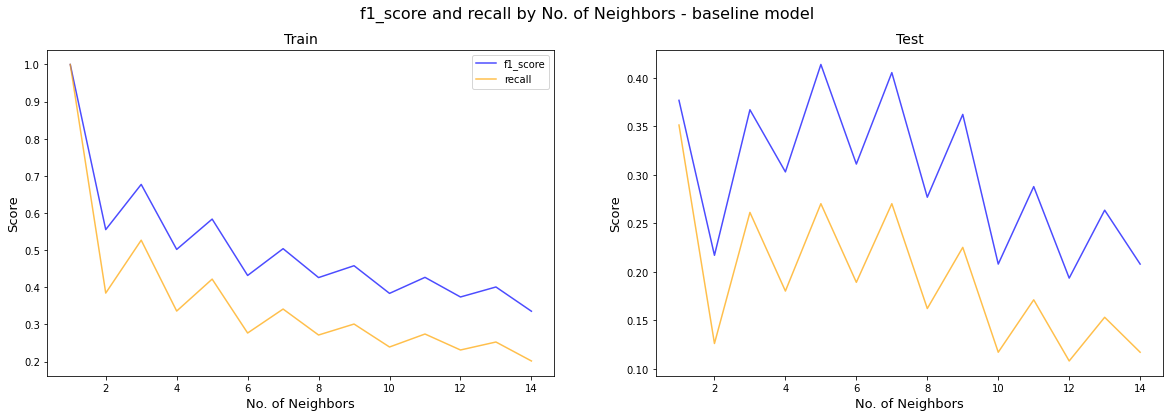

In [13]:
def knn_plot(lst, metric_1, metric_2, model_name):
    """
    Plot two metrics of a KNeighbors Classifier model for different No. of Neighbors with the goal of
    finding the optimal No. of Neighbors.

    Args:
        lst(list): List with Model Metrics.
        metric_1(str): First Metric Name.
        metric_2(str): Second Metric Name.
        model_name(str): Custom Model Name to identify which iteration to plot.
    """
    # Convert lst to DataFrame
    results_df = pd.DataFrame(lst, columns=['n_neighbors', 'precision', 'recall', 'accuracy', 
                                            'f1_score', 'neg_pred', 'true_neg', 
                                            'false_neg', 'false_pos', 'true_pos', 'model', 'split'])
    
    # Filter for chosen model and split dataframe into two (train and test)
    to_plot_train = results_df[(results_df['model'] == model_name) & (results_df['split'] == 'train')]
    to_plot_test = results_df[(results_df['model'] == model_name) & (results_df['split'] == 'test')]

    # Create Figure and Axes
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

    # Plot Metrics
    sns.lineplot(to_plot_train['n_neighbors'], to_plot_train[metric_1], color='blue', alpha=0.7, 
                 label=metric_1, err_style=None, ax=axes[0])
    sns.lineplot(to_plot_train['n_neighbors'], to_plot_train[metric_2], color='orange', alpha=0.7, 
                 label=metric_2, err_style=None, ax=axes[0])
    sns.lineplot(to_plot_test['n_neighbors'], to_plot_test[metric_1], color='blue', alpha=0.7, 
                 label=metric_1, err_style=None, ax=axes[1], legend=None)
    sns.lineplot(to_plot_test['n_neighbors'], to_plot_test[metric_2], color='orange', alpha=0.7, 
                 label=metric_2, err_style=None, ax=axes[1], legend=None)

    # Add Title, Labels and Legend
    fig.suptitle(f'{metric_1} and {metric_2} by No. of Neighbors - {model_name} model', fontsize=16)
    axes[0].set_title('Train', size=14)
    axes[1].set_title('Test', size=14)
    axes[0].set_xlabel('No. of Neighbors', size=13)
    axes[1].set_xlabel('No. of Neighbors', size=13)
    axes[0].set_ylabel('Score', size=13)
    axes[1].set_ylabel('Score', size=13)

    plt.show();

# Plot Baseline
knn_plot(knn_results, 'f1_score', 'recall', 'baseline')

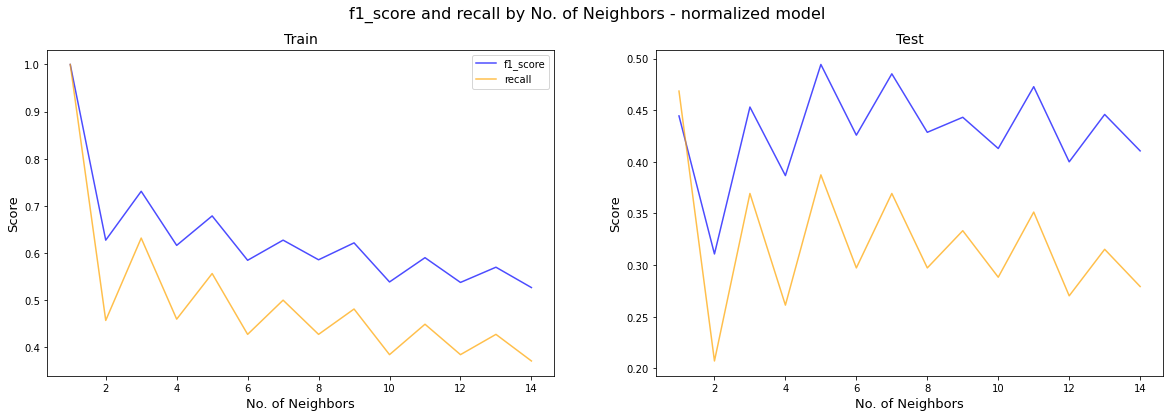

In [14]:
# Normalize Features
norm = Normalizer()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)

# Train new model + Store Metrics
knclf_report(X_train_norm, X_test_norm, y_train, y_test, knn_results, 'normalized')

# Plot metrics for the new model
knn_plot(knn_results, 'f1_score', 'recall', 'normalized')

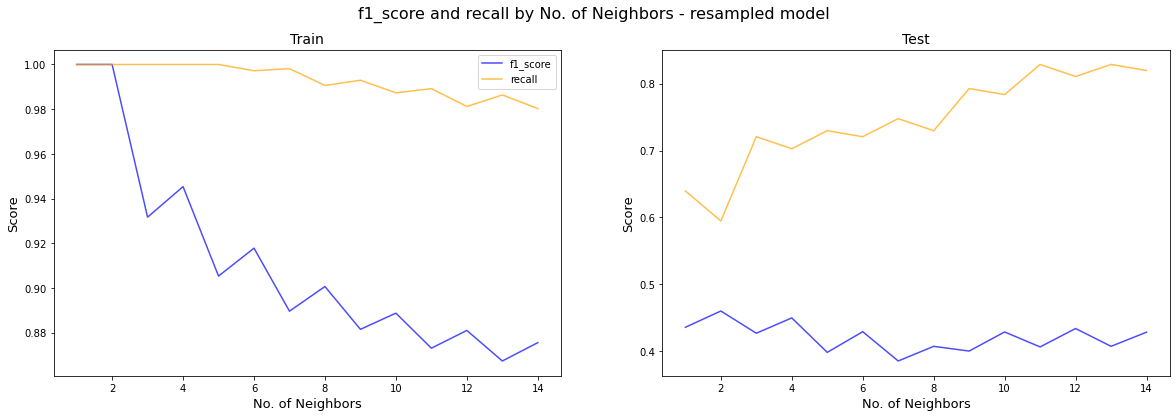

In [15]:
# Create instance of smote
smote = SMOTE(random_state=1989)

# Create resampled version of the train dataset
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_norm, y_train)

# Run Report
knclf_report(X_train_resampled, X_test_norm, y_train_resampled, y_test, knn_results, 'resampled')

# Plot
knn_plot(knn_results, 'f1_score', 'recall', 'resampled')

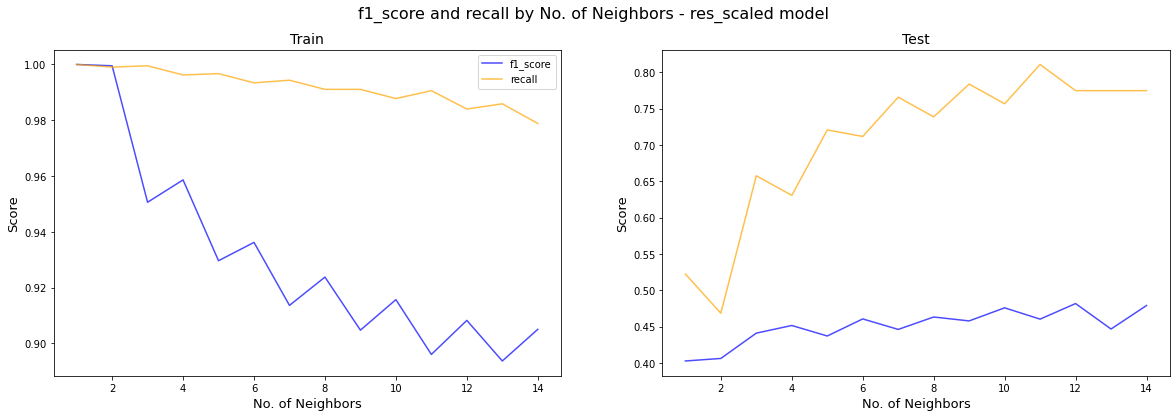

In [16]:
# Create instance of smote
smote = SMOTE(random_state=123)

# Create resampled version of the train dataset
X_train_resampled_sc, y_train_resampled_sc = smote.fit_resample(X_train, y_train)

# Run Report
knclf_report(X_train_resampled_sc, X_test, y_train_resampled_sc, y_test, knn_results, 'res_scaled')

# Plot
knn_plot(knn_results, 'f1_score', 'recall', 'res_scaled')

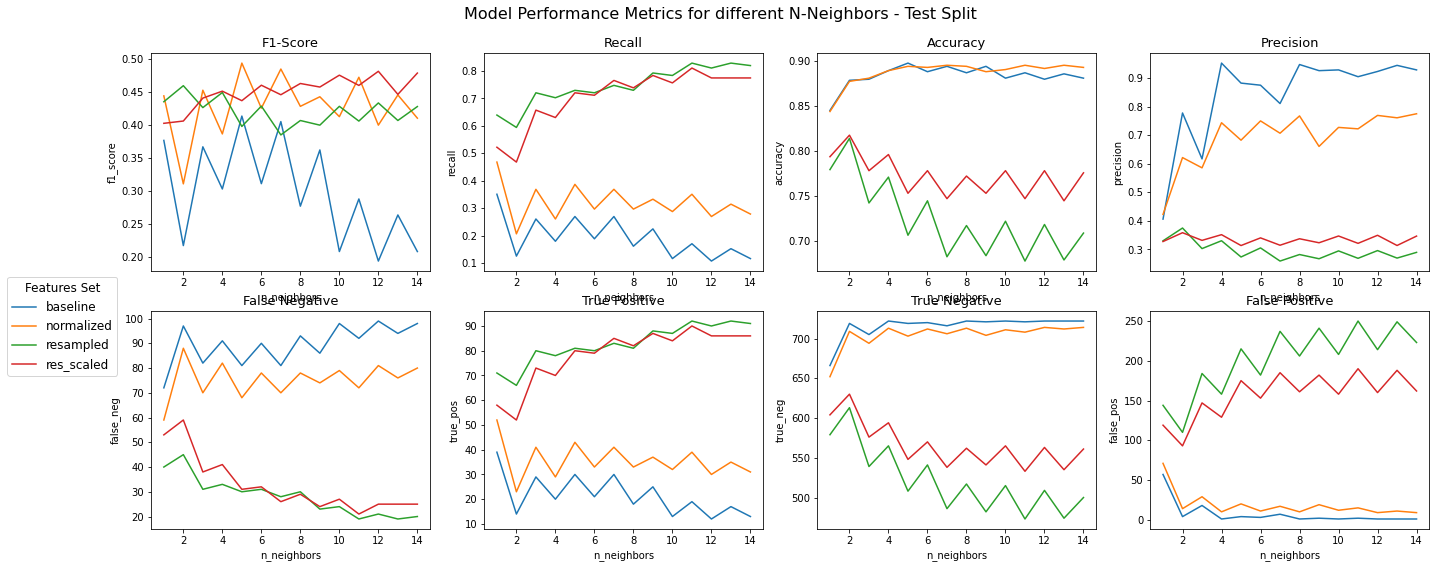

In [17]:
# Create DataFrame of models/metrics
results_df = pd.DataFrame(knn_results, columns=['n_neighbors', 'precision', 'recall', 'accuracy', 
                                                'f1_score', 'neg_pred', 'true_neg', 
                                                'false_neg', 'false_pos', 'true_pos', 'model', 'split'])

# Create Figure and Axes
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,8))

# Filter dataframe
to_plot = results_df[results_df['split'] == 'test']

# Plot Charts
sns.lineplot(x='n_neighbors', y='f1_score', hue='model', data=to_plot, ax=axes[0][0])
sns.lineplot(x='n_neighbors', y='recall', hue='model', data=to_plot, ax=axes[0][1], legend=None)
sns.lineplot(x='n_neighbors', y='accuracy', hue='model', data=to_plot, ax=axes[0][2], legend=None)
sns.lineplot(x='n_neighbors', y='precision', hue='model', data=to_plot, ax=axes[0][3], legend=None)
sns.lineplot(x='n_neighbors', y='false_neg', hue='model', data=to_plot, ax=axes[1][0], legend=None)
sns.lineplot(x='n_neighbors', y='true_pos', hue='model', data=to_plot, ax=axes[1][1], legend=None)
sns.lineplot(x='n_neighbors', y='true_neg', hue='model', data=to_plot, ax=axes[1][2], legend=None)
sns.lineplot(x='n_neighbors', y='false_pos', hue='model', data=to_plot, ax=axes[1][3], legend=None)

# Title/Label
axes[0][0].set_title('F1-Score', size=13)
axes[0][1].set_title('Recall', size=13)
axes[0][2].set_title('Accuracy', size=13)
axes[0][3].set_title('Precision', size=13)
axes[1][0].set_title('False Negative', size=13)
axes[1][1].set_title('True Positive', size=13)
axes[1][2].set_title('True Negative', size=13)
axes[1][3].set_title('False Positive', size=13)

# Adjust Legend
axes[0][0].legend(bbox_to_anchor=(-0.1, 0), title='Features Set', fontsize=12, title_fontsize=12)

# Set Title
fig.suptitle("Model Performance Metrics for different N-Neighbors - Test Split", fontsize=16)

# Add space between subplots
fig.tight_layout(h_pad=-8)

# Adjust Header Space
plt.subplots_adjust(top=0.90)
plt.show();

In [18]:
# Create Function with Report
def model_report(model, X_train, y_train, lst, sample_set, model_name):
    """
    Function to fit and test a Classification Model, generate metrics and store them in a list.

    Args:
        model(sklearn.model): Instance of a Classification Model.
        X_train(pandas.DataFrame or pandas.Series): Contains the training set of independent variables.
        X_test(pandas.DataFrame or pandas.Series): Contains the test set of independent variables.
        y_train(pandas.DataFrame or pandas.Series): Contains the training set of the dependent variable.
        y_test(pandas.DataFrame or pandas.Series): Contains the test set of the dependent variable.
        lst(list): List to store metrics.
        sample_set(str): Custom data set name to able to identify the model's performance.
        model_name(str): Custom Model Name to be able to identify the model on the list.
        
    Return:
        model(sklearn.model): Trained model instance
    """
    # Train Model
    model.fit(X_train, y_train)

    # Predict
    y_hat_train = model.predict(X_train)

    # Confusion Matrix
    conf_matrix_train = confusion_matrix(y_train, y_hat_train)
    
    # True/False Positive/Negative
    tn_train = conf_matrix_train[0][0]
    fp_train = conf_matrix_train[0][1]
    fn_train = conf_matrix_train[1][0]
    tp_train = conf_matrix_train[1][1]

    # Calculate Metrics
    ps_train = round(precision_score(y_train, y_hat_train), 2)
    rs_train = round(recall_score(y_train, y_hat_train), 2)
    acc_train = round(accuracy_score(y_train, y_hat_train), 2)
    f1_train = round(f1_score(y_train, y_hat_train), 2)
    neg_pred_train = round((fn_train / (fn_train + fp_train)), 2)
    
    # Cross Validation
    scoring = {'acc': 'accuracy', 'prec': 'precision','rec': 'recall'}
    
    cv_scores = cross_validate(model,
                               X_train, y_train,
                               scoring = scoring,
                                cv=5,
                              return_train_score=True)
    
    # Append Results to lst
    lst.append([ps_train, rs_train, acc_train, f1_train, neg_pred_train, \
                tn_train, fn_train, fp_train, tp_train, sample_set, model_name, 'train'])
    
    # Print Report
    print(f'Train \nPrecision: {ps_train} | Recall: {rs_train} | Accuracy: {acc_train}')
    print(f'F1-Score: {f1_train} | Neg Predictive: {neg_pred_train}')
    print('Confusion Matrix\n', conf_matrix_train)
    print('')
    print(f"CV \nPrecision: {cv_scores['test_prec'].mean():2f} | Recall: {cv_scores['test_rec'].mean()} | Accuracy: {cv_scores['test_acc'].mean()}")
    
    return model

# Create Empty List to Store metrics
model_results = []

In [19]:
# Scaled Features
knn_scaled = model_report(knn_cl, X_train, y_train, model_results, 'scaled', 'knn')

NameError: name 'knn_cl' is not defined

In [ ]:
# Normalized + Resampled + Scaled Features
knn_norm = model_report(knn_cl, X_train_norm, y_train, model_results, 'normalized', 'knn')

In [ ]:
# Resampled + Scaled Features
knn_resampled_sc = model_report(knn_cl, X_train_resampled_sc, y_train_resampled_sc, 
                                model_results, 'res_scaled', 'knn')

In [ ]:
def plot_metrics(model_results, model_name, model_title):
    """
    Function to plot different metrics for a given model comparing different sample sets.

    Args:
        model_results(lst): List with metrics and model/sample names.
        model_name(str): The name of the model that will be plotted.
        model_title(str): Custom Plot Title.
    """

    # Convert it to a DataFrame
    model_results_df = pd.DataFrame(model_results)
    model_results_df.columns = ['precision', 'recall', 'accuracy', 'f1_score', 'neg_pred',
                                'true_neg', 'false_neg', 'false_pos', 'true_pos', 'sample_set', 'model', 'split']
    
    # Filter for chosen model
    model_results_df = model_results_df[model_results_df['model'] == model_name]

    # Create Figure and Axes
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
    
    # Loop through Fields we will plot
    for i, pair in enumerate([('f1_score', 'F1-Score'),
                               ('accuracy', 'Accuracy'), 
                               ('recall', 'Recall'),
                               ('true_pos', 'True Positive'), 
                               ('false_neg', 'False Negative'),
                               ('false_pos', 'False Positive')]):
        
        # Calculate chart position
        col_n = i % 3
        row_n = i // 3
        
        # Define Field and Title variables
        field = pair[0]
        title = pair[1]
        
        # Print Bar Plot
        sns.barplot(data=model_results_df, x='sample_set', y=field, hue='split', ci=None, ax=axes[row_n][col_n])
        
        # Set Title
        axes[row_n][col_n].set_title(title, size=13)
        
        # If first row then set Y-Axis Range
        if row_n == 0:
            axes[row_n][col_n].set(ylim=(0, 1))
            
        # If first chart then print legend, else removes it
        if (row_n == 0) & (col_n == 0):
            axes[row_n][col_n].legend(bbox_to_anchor=(-0.1, 0), title='Data Split', fontsize=12, title_fontsize=12)
        else:
            axes[row_n][col_n].get_legend().remove()
            
        # Remove X/Y Labels
        axes[row_n][col_n].set_xlabel(None)
        axes[row_n][col_n].set_ylabel(None)
    
    # Set Title
    fig.suptitle(model_title, fontsize=18)
    
    # Adjust Header Space
    plt.subplots_adjust(top=0.92)
    plt.show();

In [ ]:
# Plot Metrics
plot_metrics(model_results, 'knn', 'K-Nearest Neighbors')

In [20]:
# Instantiate LogisticRegression
logreg = LogisticRegression(fit_intercept=False, C=1e20, solver='liblinear', random_state=123)

# Generate Report
logreg_baseline = model_report(logreg, X_train, y_train, model_results, 'baseline', 'log_reg')

Train 
Precision: 0.6 | Recall: 0.25 | Accuracy: 0.86
F1-Score: 0.35 | Neg Predictive: 0.82
Confusion Matrix
 [[2065   62]
 [ 279   93]]

CV 
Precision: 0.524251 | Recall: 0.22850450450450452 | Accuracy: 0.8543366733466933


In [21]:
# Normalized + Scaled Features
log_reg_norm = model_report(logreg, X_train_norm, y_train, 
                            model_results, 'normalized', 'log_reg')

Train 
Precision: 0.64 | Recall: 0.24 | Accuracy: 0.87
F1-Score: 0.35 | Neg Predictive: 0.85
Confusion Matrix
 [[2076   51]
 [ 281   91]]

CV 
Precision: 0.553236 | Recall: 0.2231351351351351 | Accuracy: 0.8583398797595191


In [22]:
# Resampled + Normalized + Scaled Features
log_reg_resampled = model_report(logreg, X_train_resampled, y_train_resampled, 
                                 model_results, 'resampled', 'log_reg')

Train 
Precision: 0.79 | Recall: 0.8 | Accuracy: 0.79
F1-Score: 0.79 | Neg Predictive: 0.49
Confusion Matrix
 [[1673  454]
 [ 435 1692]]

CV 
Precision: 0.779016 | Recall: 0.7870278928472797 | Accuracy: 0.7816174742517453


In [23]:
# Resampled + Scaled Features
log_reg_resampled_sc = model_report(logreg, X_train_resampled_sc, y_train_resampled_sc, 
                                    model_results, 'res_scaled', 'log_reg')

Train 
Precision: 0.78 | Recall: 0.79 | Accuracy: 0.78
F1-Score: 0.79 | Neg Predictive: 0.48
Confusion Matrix
 [[1646  481]
 [ 438 1689]]

CV 
Precision: 0.765389 | Recall: 0.784190002761668 | Accuracy: 0.7717406511370706


In [24]:
# Plot Results
plot_metrics(model_results, 'log_reg', 'Logistic Regression')

NameError: name 'plot_metrics' is not defined

In [25]:
# Different Hyperparameters
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': list(range(1,6)),
              'max_features': [20, 40, 60, None]}

# Try Different Hyperparameters
dt_clf = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid, n_jobs=-1, scoring='recall')

In [26]:
# Generate Report
dt_clf_baseline = model_report(dt_clf, X_train, y_train, model_results, 'baseline', 'dt')

Train 
Precision: 0.94 | Recall: 0.76 | Accuracy: 0.96
F1-Score: 0.84 | Neg Predictive: 0.83
Confusion Matrix
 [[2109   18]
 [  91  281]]

CV 
Precision: 0.824433 | Recall: 0.7043963963963964 | Accuracy: 0.9331743486973949


In [27]:
# Scaled Features
dt_clf_scaled = model_report(dt_clf, X_train, y_train,
                               model_results, 'scaled', 'dt')

Train 
Precision: 0.94 | Recall: 0.76 | Accuracy: 0.96
F1-Score: 0.84 | Neg Predictive: 0.83
Confusion Matrix
 [[2109   18]
 [  91  281]]

CV 
Precision: 0.824433 | Recall: 0.7043963963963964 | Accuracy: 0.9331743486973949


In [28]:
# Normalized + Resampled + Scaled Features
dt_clf_norm = model_report(dt_clf, X_train_norm, y_train, 
                             model_results, 'normalized', 'dt')

Train 
Precision: 0.94 | Recall: 0.74 | Accuracy: 0.95
F1-Score: 0.83 | Neg Predictive: 0.84
Confusion Matrix
 [[2109   18]
 [  98  274]]

CV 
Precision: 0.813433 | Recall: 0.6074954954954954 | Accuracy: 0.9199639278557115


In [29]:
# Resampled + Normalized + Scaled Features
dt_clf_resampled = model_report(dt_clf, X_train_resampled, y_train_resampled, 
                                  model_results, 'resampled', 'dt')

Train 
Precision: 0.59 | Recall: 0.94 | Accuracy: 0.65
F1-Score: 0.73 | Neg Predictive: 0.08
Confusion Matrix
 [[ 743 1384]
 [ 117 2010]]

CV 
Precision: 0.701358 | Recall: 0.9064070698702016 | Accuracy: 0.7320470035252644


In [30]:
# Resampled + Scaled Features
dt_clf_resampled_sc = model_report(dt_clf, X_train_resampled_sc, y_train_resampled_sc, 
                                  model_results, 'res_scaled', 'dt')

Train 
Precision: 0.92 | Recall: 0.87 | Accuracy: 0.89
F1-Score: 0.89 | Neg Predictive: 0.62
Confusion Matrix
 [[1957  170]
 [ 278 1849]]

CV 
Precision: 0.903030 | Recall: 0.8584733499033416 | Accuracy: 0.881279878343817


In [31]:
# Plot Metrics
plot_metrics(model_results, 'dt', 'Decision Tree')

NameError: name 'plot_metrics' is not defined

In [32]:
# Different Hyperparameters
param_grid = {'n_estimators': [30, 50],
              'criterion': ['entropy', 'gini'],
              'min_samples_leaf': [5]}

# Try Different Hyperparameters
rf_clf = GridSearchCV(RandomForestClassifier(random_state=123), param_grid, 
                           scoring='recall', n_jobs=-1)

In [33]:
# Generate Report
rf_clf_baseline = model_report(rf_clf, X_train, y_train, 
                                    model_results, 'baseline', 'rf')

Train 
Precision: 1.0 | Recall: 0.75 | Accuracy: 0.96
F1-Score: 0.85 | Neg Predictive: 0.99
Confusion Matrix
 [[2126    1]
 [  94  278]]

CV 
Precision: 0.935528 | Recall: 0.43264864864864866 | Accuracy: 0.9111663326653308


In [34]:
# Scaled Features
rf_clf_scaled = model_report(rf_clf, X_train, y_train,
                                  model_results, 'scaled', 'rf')

Train 
Precision: 1.0 | Recall: 0.75 | Accuracy: 0.96
F1-Score: 0.85 | Neg Predictive: 0.99
Confusion Matrix
 [[2126    1]
 [  94  278]]

CV 
Precision: 0.935528 | Recall: 0.43264864864864866 | Accuracy: 0.9111663326653308


In [35]:
# Normalized + Scaled Features
rf_clf_norm = model_report(rf_clf, X_train_norm, y_train, 
                                model_results, 'normalized', 'rf')

Train 
Precision: 1.0 | Recall: 0.73 | Accuracy: 0.96
F1-Score: 0.84 | Neg Predictive: 1.0
Confusion Matrix
 [[2127    0]
 [ 101  271]]

CV 
Precision: 0.958105 | Recall: 0.44068468468468475 | Accuracy: 0.9139663326653306


In [36]:
# Resampled + Scaled + Normalized Features
rf_clf_resampled = model_report(rf_clf, X_train_resampled, y_train_resampled, 
                                     model_results, 'resampled', 'rf')

Train 
Precision: 0.99 | Recall: 0.97 | Accuracy: 0.98
F1-Score: 0.98 | Neg Predictive: 0.76
Confusion Matrix
 [[2107   20]
 [  64 2063]]

CV 
Precision: 0.950567 | Recall: 0.912075117370892 | Accuracy: 0.932065528444045


In [37]:
# Resampled + Scaled Features
rf_clf_resampled_sc = model_report(rf_clf, X_train_resampled_sc, y_train_resampled_sc, 
                                   model_results, 'res_scaled', 'rf')

Train 
Precision: 0.99 | Recall: 0.97 | Accuracy: 0.98
F1-Score: 0.98 | Neg Predictive: 0.84
Confusion Matrix
 [[2115   12]
 [  65 2062]]

CV 
Precision: 0.957521 | Recall: 0.9299276442971556 | Accuracy: 0.9440541922997167


In [ ]:
# Plot Metrics
plot_metrics(model_results, 'rf', 'Random Forest')

In [38]:
# Create Model Instance
xgbc_clf = XGBClassifier(random_state=42)

In [39]:
# Generate Report
xgbc_clf_baseline = model_report(xgbc_clf, X_train, y_train, 
                                    model_results, 'baseline', 'xgbc')

Train 
Precision: 1.0 | Recall: 1.0 | Accuracy: 1.0
F1-Score: 1.0 | Neg Predictive: nan
Confusion Matrix
 [[2127    0]
 [   0  372]]

CV 
Precision: 0.915095 | Recall: 0.7392792792792793 | Accuracy: 0.9507807615230461


In [40]:
# Scaled Features
xgbc_clf_scaled = model_report(xgbc_clf, X_train, y_train,
                                  model_results, 'scaled', 'xgbc')

Train 
Precision: 1.0 | Recall: 1.0 | Accuracy: 1.0
F1-Score: 1.0 | Neg Predictive: nan
Confusion Matrix
 [[2127    0]
 [   0  372]]

CV 
Precision: 0.915095 | Recall: 0.7392792792792793 | Accuracy: 0.9507807615230461


In [41]:
# Normalized + Resampled + Scaled Features
xgbc_clf_norm = model_report(xgbc_clf, X_train_norm, y_train, 
                                model_results, 'normalized', 'xgbc')

Train 
Precision: 1.0 | Recall: 1.0 | Accuracy: 1.0
F1-Score: 1.0 | Neg Predictive: nan
Confusion Matrix
 [[2127    0]
 [   0  372]]

CV 
Precision: 0.875112 | Recall: 0.6799999999999999 | Accuracy: 0.9375775551102205


In [42]:
# Resampled + Scaled Features
xgbc_clf_resampled = model_report(xgbc_clf, X_train_resampled, y_train_resampled, 
                                     model_results, 'resampled', 'xgbc')

Train 
Precision: 1.0 | Recall: 1.0 | Accuracy: 1.0
F1-Score: 1.0 | Neg Predictive: nan
Confusion Matrix
 [[2127    0]
 [   0 2127]]

CV 
Precision: 0.970718 | Recall: 0.9571886219276443 | Accuracy: 0.9640364968549111


In [43]:
# Resampled + Scaled Features
xgbc_clf_resampled_sc = model_report(xgbc_clf, X_train_resampled_sc, y_train_resampled_sc, 
                                     model_results, 'res_scaled', 'xgbc')

Train 
Precision: 1.0 | Recall: 1.0 | Accuracy: 1.0
F1-Score: 1.0 | Neg Predictive: nan
Confusion Matrix
 [[2127    0]
 [   0 2127]]

CV 
Precision: 0.979276 | Recall: 0.9501231703949186 | Accuracy: 0.9647426556991775


In [ ]:
# Plot Metrics
plot_metrics(model_results, 'xgbc', 'XGBoost')

In [44]:
# Create DataFrame with model results
model_results_df = pd.DataFrame(model_results)
model_results_df.columns = ['precision', 'recall', 'accuracy', 'f1_score', 'neg_pred', 
                            'true_neg', 'false_neg', 'false_pos', 'true_pos', 'sample_set', 'model', 'split']

In [45]:
# Different Hyperparameters
param_grid = {'max_depth' : [4, 6, 8],
             'learning_rate' : [.1, .01, .001],
              'min_child_weight' : [1, 5, 10]
             }

# Try Different Hyperparameters
xgbc_new = GridSearchCV(XGBClassifier(random_state=42), param_grid, n_jobs=-1, scoring='recall')

In [46]:
# Train new model
xgbc_new_gs = model_report(xgbc_new, X_train_resampled_sc, y_train_resampled_sc, 
                             model_results, 'res_scaled_optimized', 'xgbc')

Train 
Precision: 1.0 | Recall: 0.99 | Accuracy: 1.0
F1-Score: 1.0 | Neg Predictive: 1.0
Confusion Matrix
 [[2127    0]
 [  12 2115]]

CV 
Precision: 0.977267 | Recall: 0.9529544324772162 | Accuracy: 0.9652126909518215


In [47]:
# Best Hyperparameters
dt_clf_new.best_params_

NameError: name 'dt_clf_new' is not defined

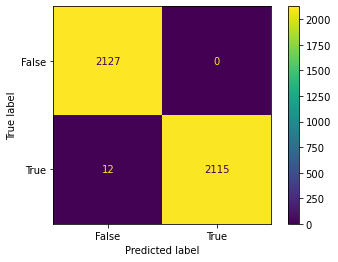

In [48]:
plot_confusion_matrix(xgbc_new, X_train_resampled_sc, y_train_resampled_sc);

In [49]:
y_test_hat = xgbc_new.predict(X_test)

xgbc_new.score(X_test, y_test)

0.8468468468468469

In [50]:
recall_score(y_test, y_test_hat)

0.8468468468468469

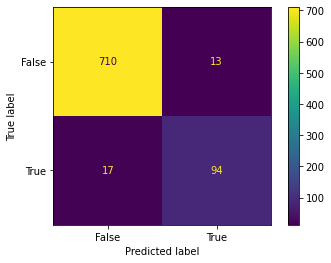

In [51]:
plot_confusion_matrix(xgbc_new, X_test, y_test);

In [52]:
X = pd.DataFrame(X_test)

In [53]:
# Create List with Feature Name and Weight
features_lst = []
for i in zip(list(X.columns), dt_clf_new.best_estimator_.feature_importances_):
    features_lst.append(i)

# Create Dataframe and sort values to plot
dt_features = pd.DataFrame(features_lst, columns=['feature', 'weight'])
dt_features = dt_features.sort_values('weight').reset_index(drop=True)

NameError: name 'dt_clf_new' is not defined

In [54]:
dt_features.sort_values('weight', ascending=False).head(10)

NameError: name 'dt_features' is not defined